In [12]:
# Load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow import keras
from keras import layers
from keras import models
from sklearn.metrics import mean_absolute_error, mean_squared_error

1. Load and Review the Dataset

In [13]:
# import pandas as pd

# Load the train and test datasets
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

# Display the first few rows of the train dataset
print("First few rows of the train dataset:")
print(train_df.head())

# Display summary statistics of the train dataset
print("\nSummary statistics of the train dataset:")
print(train_df.describe())

# List the column names of the train dataset
print("\nColumn names of the train dataset:")
print(train_df.columns.tolist())

# Display the first few rows of the test dataset
print("\nFirst few rows of the test dataset:")
print(test_df.head())

# Display summary statistics of the test dataset
print("\nSummary statistics of the test dataset:")
print(test_df.describe())

# List the column names of the test dataset
print("\nColumn names of the test dataset:")
print(test_df.columns.tolist())


First few rows of the train dataset:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleConditi

2. Basic Statistical Analysis

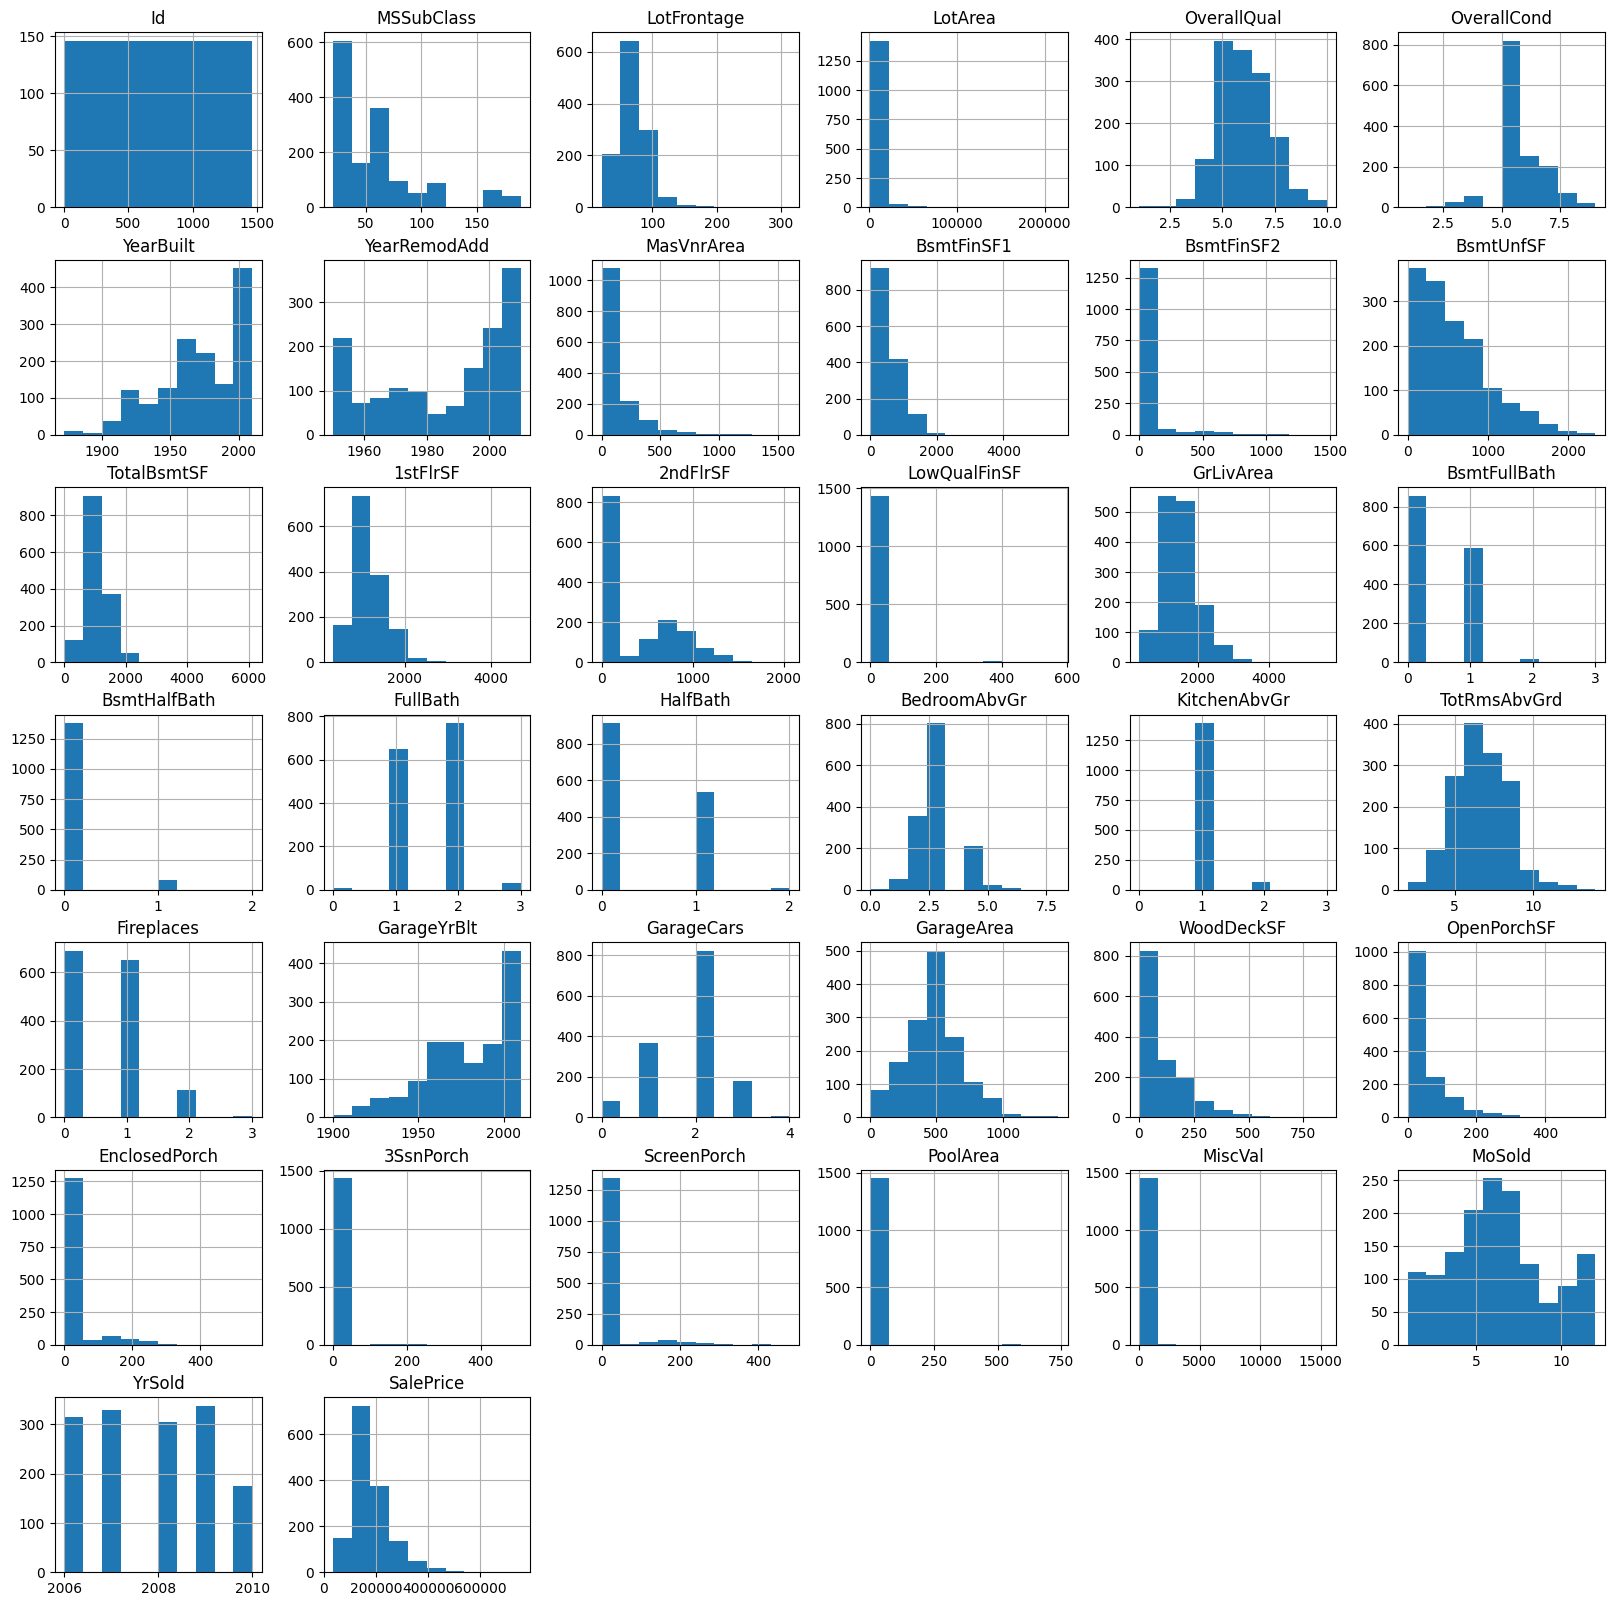

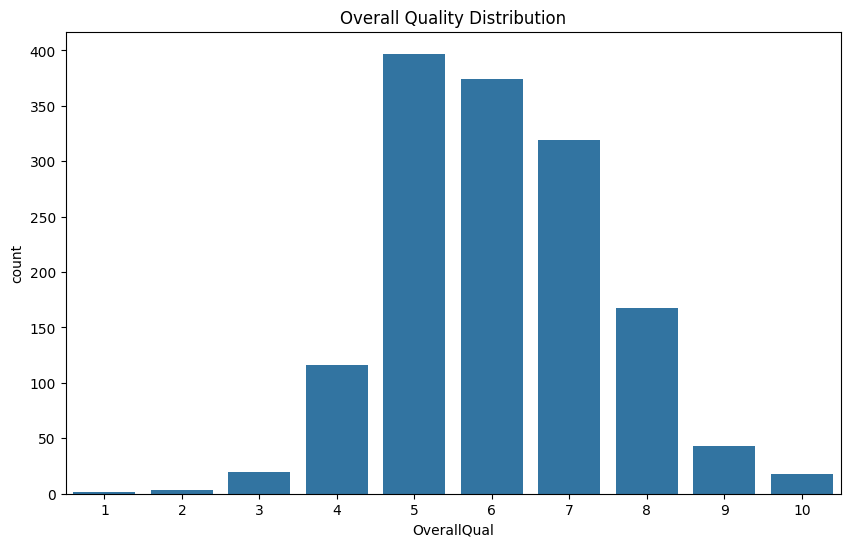

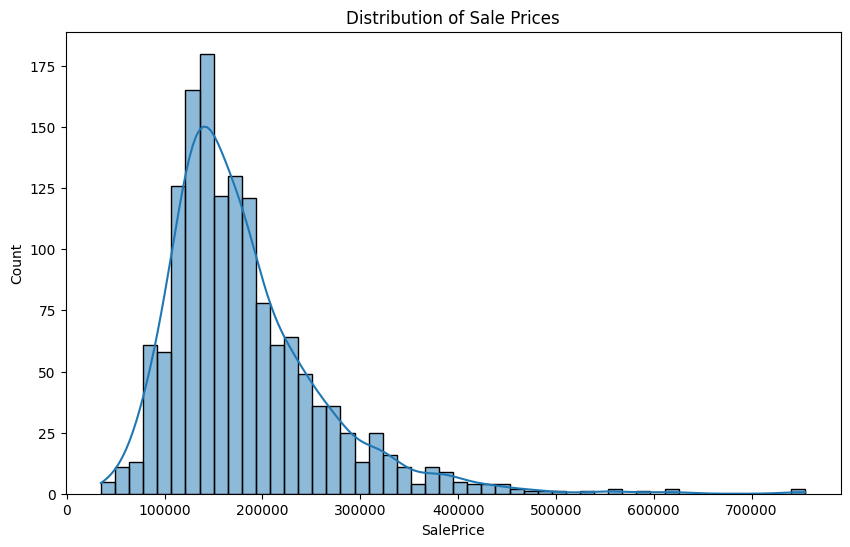

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograms for key features
train_df.hist(figsize=(20, 20))     # create histograms for all numerical features in the dataset
plt.show()                          # display the plots

# Bar plot of overall quality
plt.figure(figsize=(10, 6))                     # set the figure size
sns.countplot(x='OverallQual', data=train_df)   # create a count plot for the OverallQual column
plt.title('Overall Quality Distribution')       # add a title to the plot
plt.show()                                    # display the plot

# Distribution of sale prices
plt.figure(figsize=(10, 6))                     # set the figure size
sns.histplot(train_df['SalePrice'], bins=50, kde=True)  # create a histogram with a kernel density estimate for the SalePrice column
plt.title('Distribution of Sale Prices')                # add a title to the plot
plt.show()                                              # display the plot


3. Feature Analysis

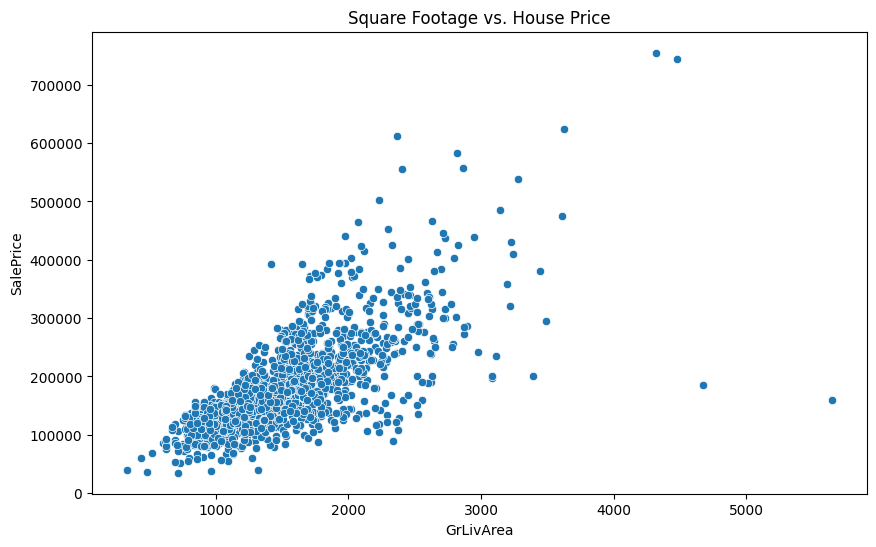

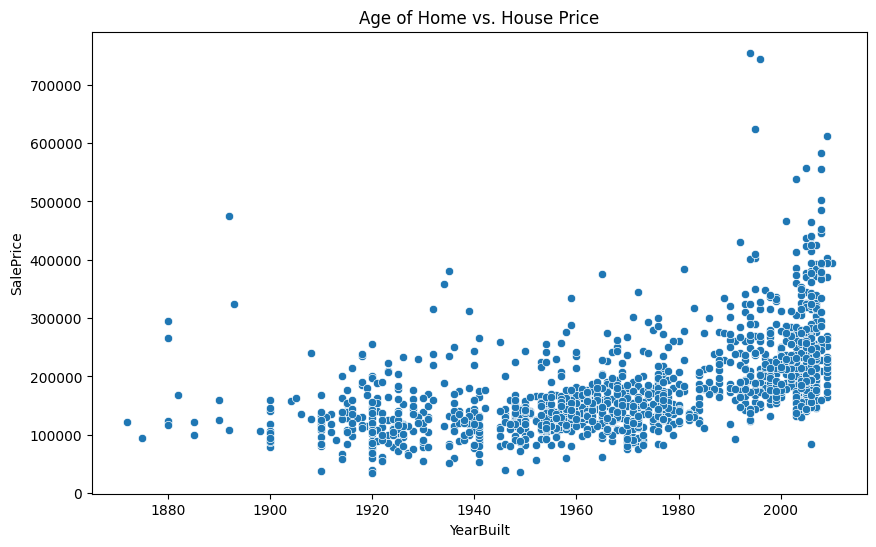

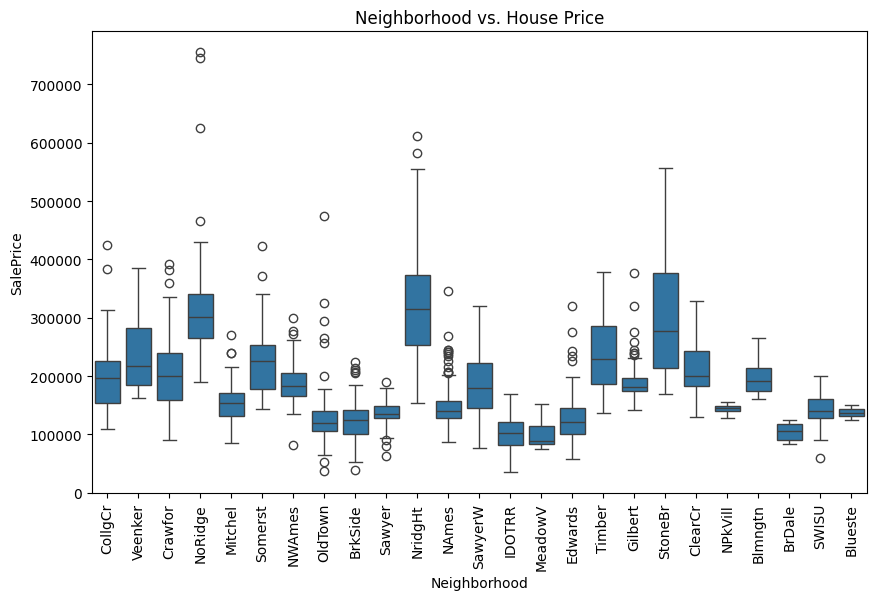

In [15]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# Scatter plot of square footage vs. house price
plt.figure(figsize=(10, 6))  # Set the figure size
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_df)  # Create a scatter plot for square footage (GrLivArea) vs. house price (SalePrice)
plt.title('Square Footage vs. House Price')  # Add a title to the plot
plt.show()  # Display the plot

# Scatter plot of age of home vs. house price
plt.figure(figsize=(10, 6))  # Set the figure size
sns.scatterplot(x='YearBuilt', y='SalePrice', data=train_df)  # Create a scatter plot for the age of home (YearBuilt) vs. house price (SalePrice)
plt.title('Age of Home vs. House Price')  # Add a title to the plot
plt.show()  # Display the plot

# Scatter plot of neighborhood vs. house price
plt.figure(figsize=(10, 6))  # Set the figure size
sns.boxplot(x='Neighborhood', y='SalePrice', data=train_df)  # Create a box plot for neighborhood (Neighborhood) vs. house price (SalePrice)
plt.title('Neighborhood vs. House Price')  # Add a title to the plot
plt.xticks(rotation=90)  # Rotate the x-axis labels by 90 degrees for better readability
plt.show()  # Display the plot


4. Data Processing and Feature Engineering 

First, the data needs to be cleaned and preprocessed. To start, let's handle missing values. 

In [16]:
# Check for missing values
missing_values = train_df.isnull().sum()
print(missing_values[missing_values > 0])

# Fill missing values for numerical columns with the median and for categorical columns with the mode
numerical_cols = train_df.select_dtypes(include=[np.number]).columns
categorical_cols = train_df.select_dtypes(include=[object]).columns

num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

train_df[numerical_cols] = num_imputer.fit_transform(train_df[numerical_cols])
train_df[categorical_cols] = cat_imputer.fit_transform(train_df[categorical_cols])

# Drop unnecessary columns
train_df.drop(columns=['Id'], inplace=True)

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


Use one-hot encoding for categorical variables to convert them into numerical format. Standardize the numerical features to have zero mean and unit variance. 

In [26]:
# One-hot encode categorical variables
train_df = pd.get_dummies(train_df, drop_first=True)

# Update numerical columns after one-hot encoding
numerical_cols = train_df.select_dtypes(include=[np.number]).columns

# Standardize numerical features
scaler = StandardScaler()
train_df[numerical_cols] = scaler.fit_transform(train_df[numerical_cols])

Now that the data has been cleaned and scaled, let's generate the correlation matrix to identify the strong correlations between various features and the sale price. 

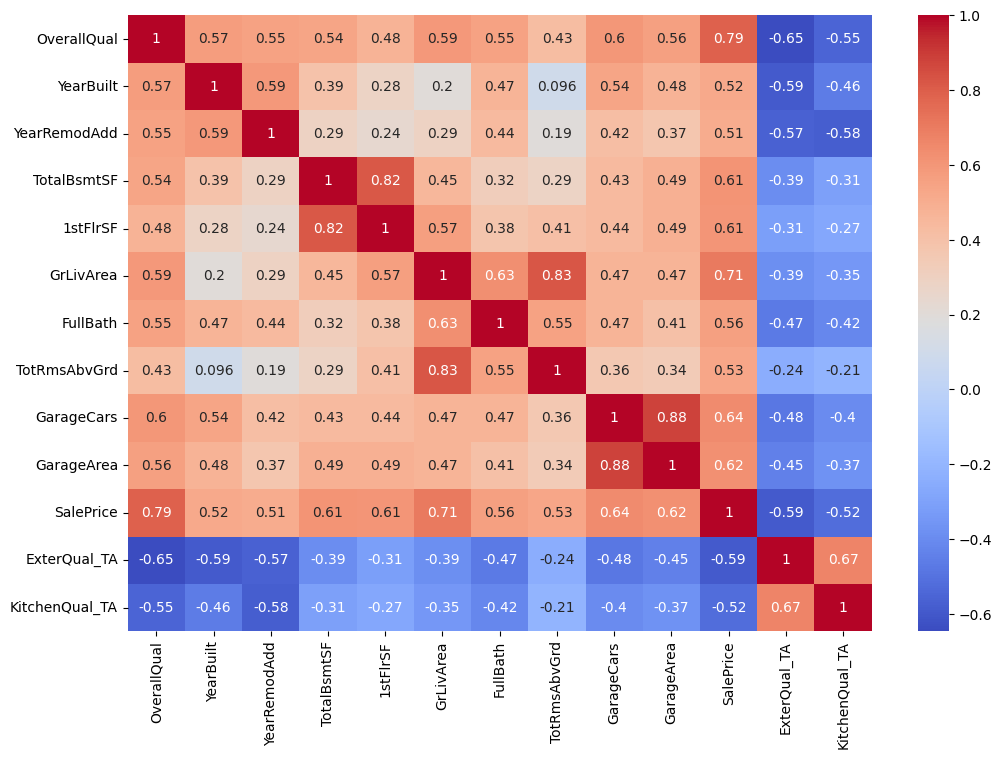

In [27]:
# Calculate the correlation matrix
correlation_matrix = train_df.corr()
high_corr_features = correlation_matrix.index[abs(correlation_matrix["SalePrice"]) > 0.5]

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(train_df[high_corr_features].corr(), annot=True, cmap='coolwarm')
plt.show()

In [28]:
# Identify features with high correlation to SalePrice, excluding SalePrice itself
print("Highly correlated features with SalePrice:")
print(correlation_matrix["SalePrice"][high_corr_features])

Highly correlated features with SalePrice:
OverallQual       0.790982
YearBuilt         0.522897
YearRemodAdd      0.507101
TotalBsmtSF       0.613581
1stFlrSF          0.605852
GrLivArea         0.708624
FullBath          0.560664
TotRmsAbvGrd      0.533723
GarageCars        0.640409
GarageArea        0.623431
SalePrice         1.000000
ExterQual_TA     -0.589044
KitchenQual_TA   -0.519298
Name: SalePrice, dtype: float64


Analysis of Highly Correlated Features

Positive Correlations:

    OverallQual (0.790982): Indicates that the overall quality of the house is a strong predictor of the sale price.

    GrLivArea (0.708624): Shows that the above-ground living area size significantly impacts the sale price.

    GarageArea (0.623431) and GarageCars (0.640409): Suggests that the size and number of garage spaces are important factors.

    TotalBsmtSF (0.613581) and 1stFlrSF (0.605852): Indicate that the total basement area and the first-floor square footage are strong predictors.

    FullBath (0.560664) and TotRmsAbvGrd (0.533723): The number of full bathrooms and total rooms above ground also correlate positively.

    YearBuilt (0.522897) and YearRemodAdd (0.507101): Newer houses and those with recent remodels tend to have higher sale prices.

Negative Correlations:

    ExterQual_TA (-0.589044) and KitchenQual_TA (-0.519298): Houses with 'Typical/Average' quality in exterior and kitchen quality tend to have lower sale prices.

    GarageFinish_Unf (-0.513906): Houses with unfinished garages tend to sell for less.

Next, I want to check for multicollinearity by checking that pairs of features with high correlation. In order to address the mulitcollinearity, I will need to either remove one of the features, perform a Principal Component Analysis (PCA), and/or use regularization techniques.

In [30]:
# Check for multicollinearity
corr_matrix = train_df[high_corr_features].corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find index of feature columns with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

print("Columns to consider dropping due to high multicollinearity:")
print(to_drop)

Columns to consider dropping due to high multicollinearity:
['1stFlrSF', 'TotRmsAbvGrd', 'GarageArea']


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

ATTEMPT 1: SAVING CONTENTS IN CASE THERE IS USABLE DATA

To determine which features to prioritize in our models, I would like to observe which feature or combination of features generates the tightest cluster of home prices on a scatter plot, demosntarting a direct assocation between the feature(s) and the listed price. 

To determine the feature or group of features that have a strong association with the listed price, we can create scatter plots between each feature or group of features and the sale price as well as calculate the correlation coefficient and count the number of data points within 1 standard deviation of the mean (find the tightest cluster). This will help us identify any patterns or relationships between the variables.


First, I want to assess the clusters of the 10 most impactful singular features as described above. 

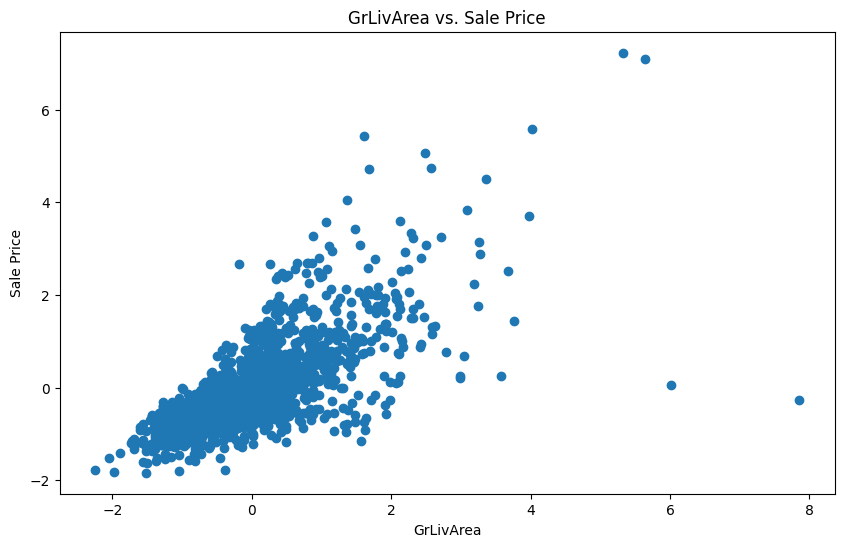

In [19]:
import matplotlib.pyplot as plt

# Scatter plot of feature vs. sale price
plt.figure(figsize=(10, 6))  # Set the figure size

# Example: Scatter plot of GrLivArea vs. SalePrice
plt.scatter(train_df['GrLivArea'], train_df['SalePrice'])  # Create a scatter plot for GrLivArea vs. SalePrice

plt.title('GrLivArea vs. Sale Price')  # Add a title to the plot
plt.xlabel('GrLivArea')  # Add x-axis label
plt.ylabel('Sale Price')  # Add y-axis label

plt.show()  # Display the plot


In [20]:
# Calculate the correlation coefficient between the two variables
correlation_coefficient = train_df['GrLivArea'].corr(train_df['SalePrice'])

# Print the correlation coefficient
print(f"Correlation coefficient: {correlation_coefficient}")

# Calculate the standard deviation of the SalePrice variable
std_dev = train_df['SalePrice'].std()

# Calculate the mean of the SalePrice variable
mean = train_df['SalePrice'].mean()

# Calculate the z-score for each data point
z_scores = (train_df['SalePrice'] - mean) / std_dev

# Count the number of data points within 1 standard deviation of the mean
within_1_std_dev = len(z_scores[(z_scores >= -1) & (z_scores <= 1)])

# Count the total number of data points
total_data_points = len(train_df)

# Calculate the percentage of data points within 1 standard deviation of the mean
percentage_within_1_std_dev = (within_1_std_dev / total_data_points) * 100

# Print the percentage of data points within 1 standard deviation of the mean
print(f"Percentage within 1 standard deviation: {percentage_within_1_std_dev}%")

Correlation coefficient: 0.7086244776126519
Percentage within 1 standard deviation: 78.42465753424658%


This code calculates the correlation coefficient between the 'GrLivArea' and 'SalePrice' variables, and then calculates the z-scores for the 'SalePrice' variable. It counts the number of data points within 1 standard deviation of the mean and calculates the percentage of data points within 1 standard deviation.

The goal is to determine which of the 10 features show the greatest immeiate correlation to the the sale price. 

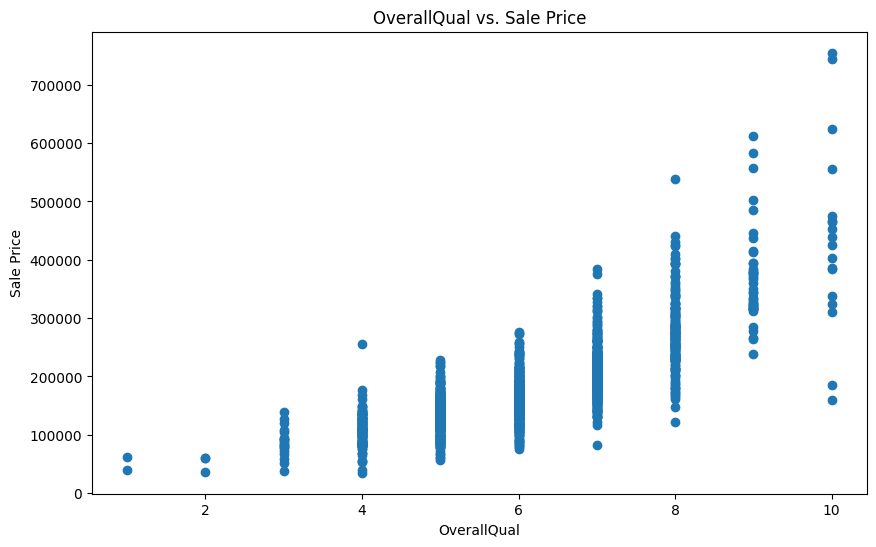

Correlation coefficient for OverallQual: 0.7909816005838044
Percentage within 1 standard deviation for OverallQual: 78.42465753424658%



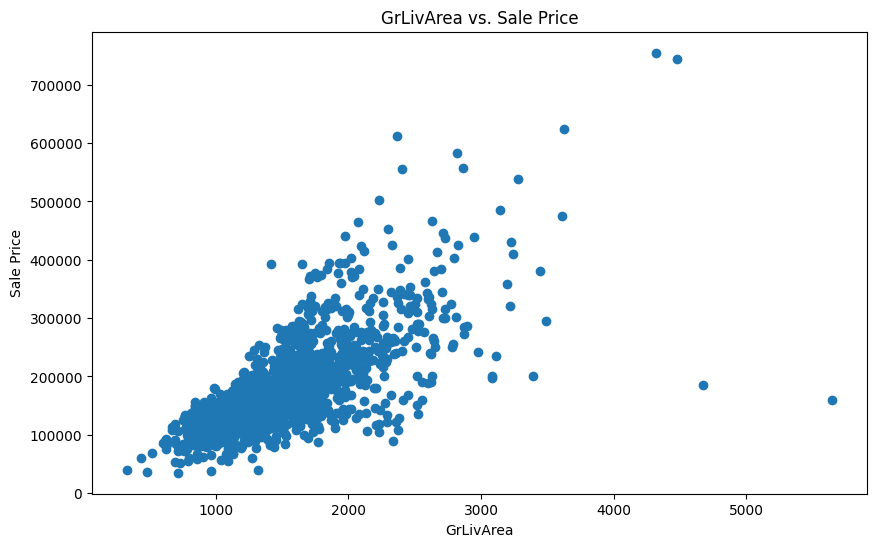

Correlation coefficient for GrLivArea: 0.7086244776126523
Percentage within 1 standard deviation for GrLivArea: 78.42465753424658%



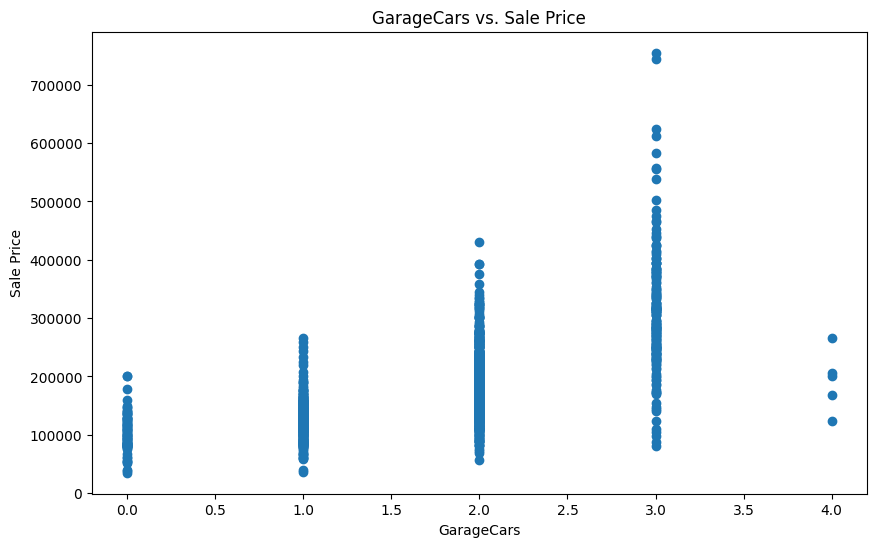

Correlation coefficient for GarageCars: 0.6404091972583529
Percentage within 1 standard deviation for GarageCars: 78.42465753424658%



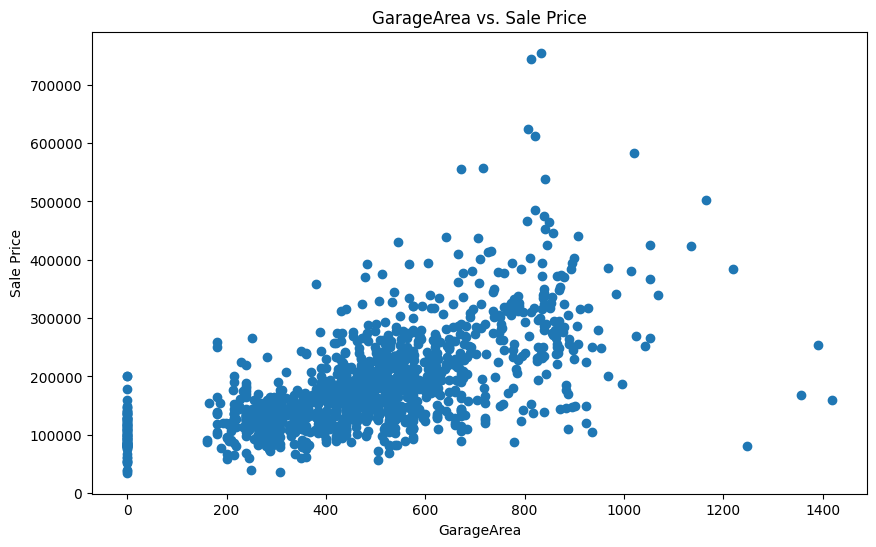

Correlation coefficient for GarageArea: 0.6234314389183618
Percentage within 1 standard deviation for GarageArea: 78.42465753424658%



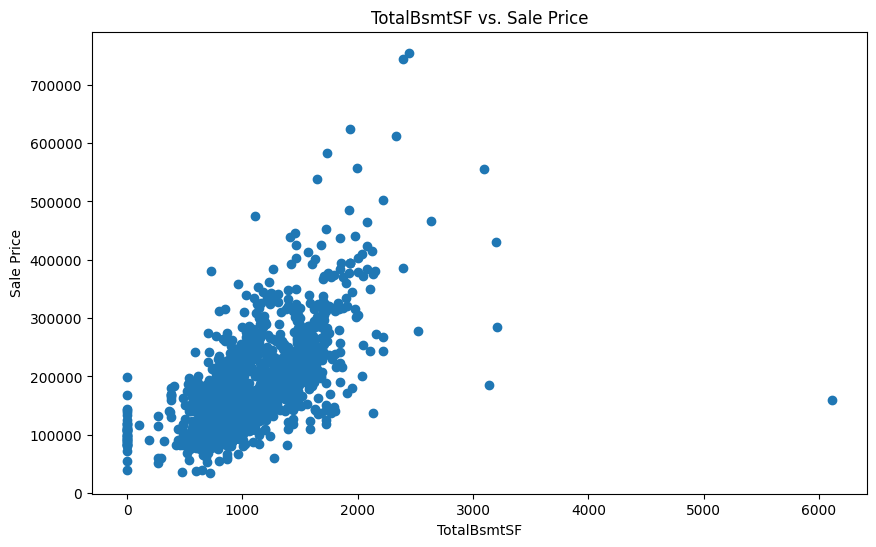

Correlation coefficient for TotalBsmtSF: 0.6135805515591956
Percentage within 1 standard deviation for TotalBsmtSF: 78.42465753424658%



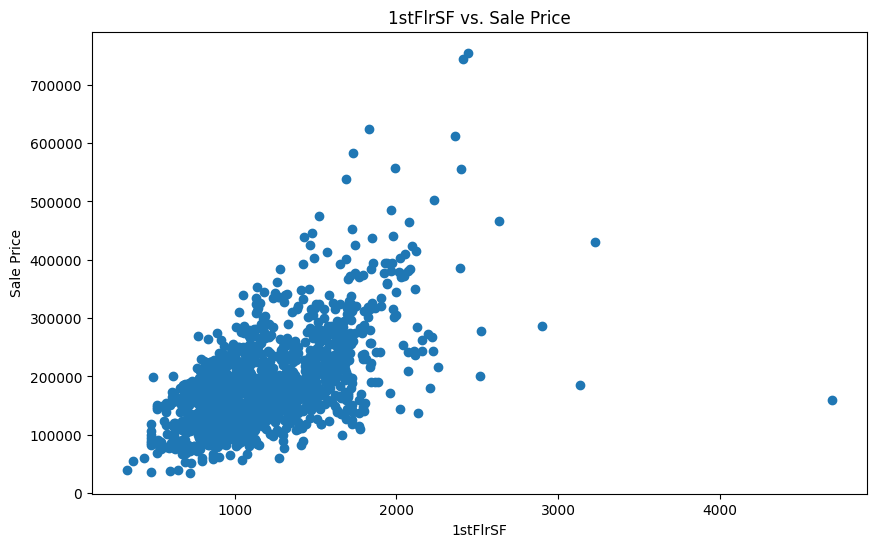

Correlation coefficient for 1stFlrSF: 0.6058521846919147
Percentage within 1 standard deviation for 1stFlrSF: 78.42465753424658%



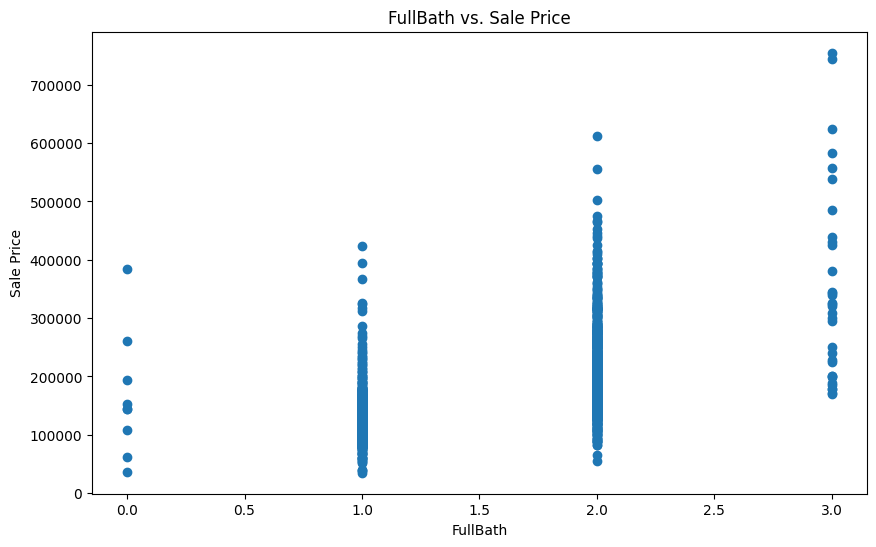

Correlation coefficient for FullBath: 0.5606637627484449
Percentage within 1 standard deviation for FullBath: 78.42465753424658%



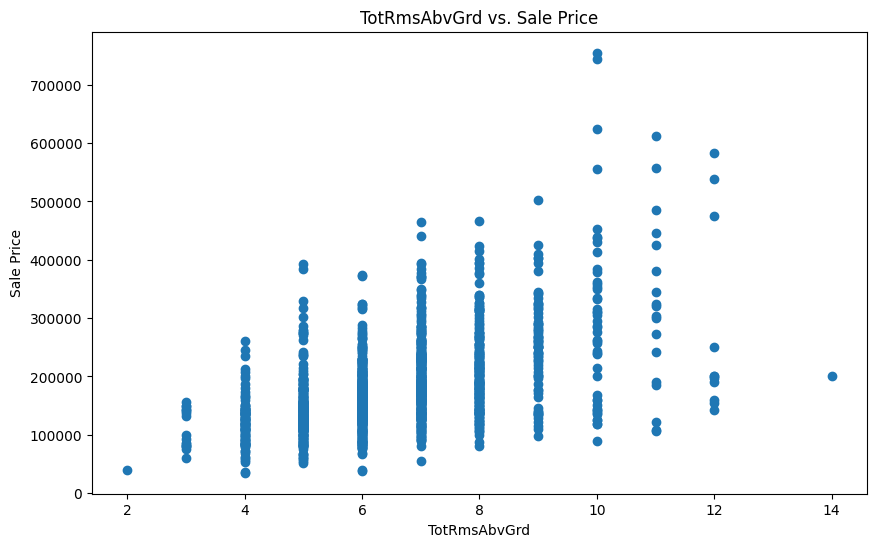

Correlation coefficient for TotRmsAbvGrd: 0.5337231555820282
Percentage within 1 standard deviation for TotRmsAbvGrd: 78.42465753424658%



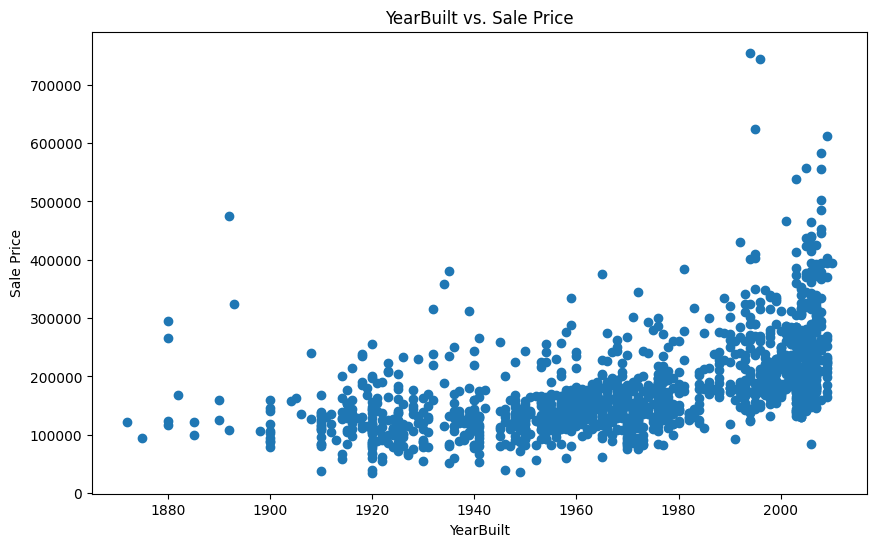

Correlation coefficient for YearBuilt: 0.5228973328794969
Percentage within 1 standard deviation for YearBuilt: 78.42465753424658%



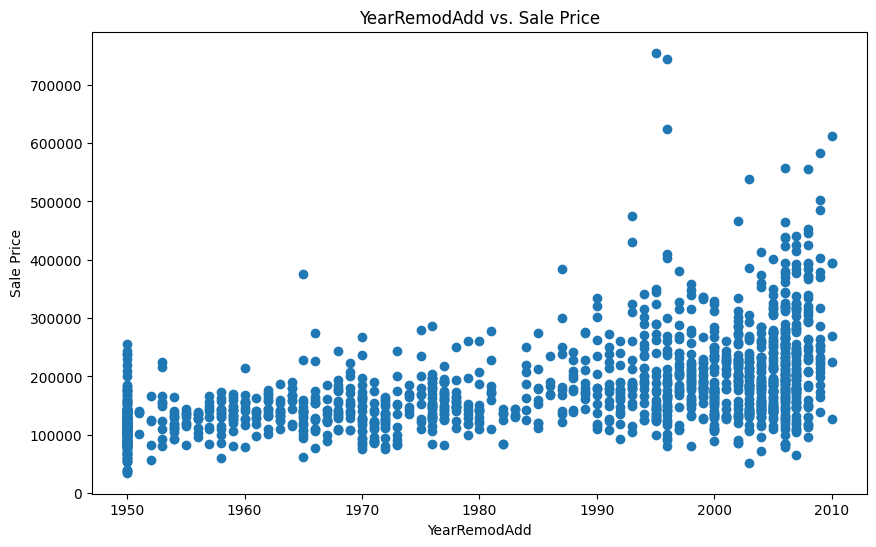

Correlation coefficient for YearRemodAdd: 0.5071009671113865
Percentage within 1 standard deviation for YearRemodAdd: 78.42465753424658%



In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
train_df = pd.read_csv('../data/train.csv')

# List of all features excluding target variable 'SalePrice'
features = train_df.columns.tolist()
features.remove('SalePrice')

# Dictionary to store correlation coefficients
correlation_dict = {}

# Calculate correlation coefficients for each numerical feature
for feature in features:
    if pd.api.types.is_numeric_dtype(train_df[feature]):
        correlation_coefficient = train_df[feature].corr(train_df['SalePrice'])
        correlation_dict[feature] = abs(correlation_coefficient)

# Select the top 10 features with the highest absolute correlation coefficients
top_10_features = sorted(correlation_dict, key=correlation_dict.get, reverse=True)[:10]

# Loop through each feature and generate scatter plots, calculate correlation coefficient, and percentage within 1 standard deviation
for feature in top_10_features:
    # Check if the feature is numerical for scatter plot and correlation calculation
    if pd.api.types.is_numeric_dtype(train_df[feature]):
        # Generate scatter plot
        plt.figure(figsize=(10, 6))
        plt.scatter(train_df[feature], train_df['SalePrice'])
        plt.title(f'{feature} vs. Sale Price')
        plt.xlabel(feature)
        plt.ylabel('Sale Price')
        plt.show()

        # Calculate the correlation coefficient
        correlation_coefficient = train_df[feature].corr(train_df['SalePrice'])
        print(f"Correlation coefficient for {feature}: {correlation_coefficient}")

        # Calculate the standard deviation and mean of the SalePrice variable
        std_dev = train_df['SalePrice'].std()
        mean = train_df['SalePrice'].mean()

        # Calculate the z-score for each data point
        z_scores = (train_df['SalePrice'] - mean) / std_dev

        # Count the number of data points within 1 standard deviation of the mean
        within_1_std_dev = len(z_scores[(z_scores >= -1) & (z_scores <= 1)])
        total_data_points = len(train_df)

        # Calculate the percentage of data points within 1 standard deviation of the mean
        percentage_within_1_std_dev = (within_1_std_dev / total_data_points) * 100
        print(f"Percentage within 1 standard deviation for {feature}: {percentage_within_1_std_dev}%\n")
